# <div style="color:white;display:fill;border-radius:5px;background-color:#CC6C6C;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:110%"><b>1 |</b>  Introduction</p></div>
Cardiovascular diseases are a group of disorders involving the heart and blood vessels and one of the leading causes of death globally, according to the [American Heart Association](https://www.ahajournals.org/doi/10.1161/CIR.0000000000000950?utm_campaign=ahajournals&utm_source=heart&utm_medium=link&utm_content=statshome). In 2019, cardiovascular diseases took the lives of nearly 18 million people, accounting for 32% of deaths worldwide [(World Health Organization, 2021)](https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds). 85% of these deaths were due to heart attacks and strokes, with 38% among people under the age of 70. Early detection is critical in the treatment and management of cardiovascular diseases, wherein machine learning can be a powerful tool in detecting a potential heart disease diagnosis. In this notebook, I'll develop a Gradient Boosting model to predict the presence of cardiovascular disease and identify some of the most important predictors based on their Shapley values. 

# <div style="color:white;display:fill;border-radius:5px;background-color:#CC6C6C;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:110%"><b>2 |</b> Data Overview</p></div>
The [Heart Disease data](https://www.kaggle.com/fedesoriano/heart-failure-prediction) used in this study is a synthesis of data sets sourced from the UCI Machine Learning Repository and contains 11 features that can be used to predict the presence of heart failure, a common cardiovascular disease that greatly increases the risk of a CV-related death. The target variable is a binary attribute indicating a diagnosis of Heart Failure when `HeartDisease` = 1.
## <b><span style='color:#CF6161'>2.1</span> | Variable Description</b>
1. **`Age`**: The age of the patient, in years.
2. **`Sex`**: The patient's gender, male or female.
3. **`ChestPainType`**: The type of chest pain experienced by the patient:  
    i. `TA`: Typical Angina  
    ii. `ATA`: Atypical Angina  
    iii. `NAP`: Non-Anginal Pain  
    iv. `ASY`: Asymptomatic
4. **`RestingBP`**: The patient's resting blood pressure (mmHg).
5. **`Cholesterol`**: The patient's serum cholesterol (mg/dl).
6. **`FastingBS`**: The patient's fasting blood sugar.  
    i. `1` if glucose > 120 mg/dl  
    ii. `0` otherwise
7. **`RestingECG`**: Resting electrocardiogram results:  
    i. `Normal`  
    ii. `ST`: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)  
    iii. `LVH`: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. **`MaxHR`**: Maximum heart rate achieved, beats per minute.
9. **`ExerciseAngina`**: Exercise-induced angina, yes or no.
10. **`Oldpeak`**: Numeric measure of ST depression induced by exercise relative to rest.
11. **`ST_Slope`**: The slope of the peak exercise ST segment.   
    i. `Up`: upsloping  
    ii. `Flat`  
    iii. `Down`: downsloping   

## <b><span style='color:#CF6161'>2.2</span> | Summary Statistics of Numeric Variables</b>

In [1]:
import warnings, copy
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot, init_notebook_mode
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import chi2_contingency 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import shap
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, classification_report
init_notebook_mode(connected=True)

# Load data
heart = pd.read_csv("/Users/victorchudnovskiy/Documents/Netologiya/Downloads/heart.csv")
print("There are {:,} observations and {} columns in the data set.".format(heart.shape[0], heart.shape[1]))
print("There are {} missing values in the data.".format(heart.isna().sum().sum()))
heart.describe().round(3)

There are 918 observations and 12 columns in the data set.
There are 0 missing values in the data.


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000,918.000,918.000,918.000,918.000,918.000,918.000
mean,53.511,132.397,198.800,0.233,136.809,0.887,0.553
std,9.433,18.514,109.384,0.423,25.460,1.067,0.497
min,28.000,0.000,0.000,0.000,60.000,-2.600,0.000
25%,47.000,120.000,173.250,0.000,120.000,0.000,0.000
50%,54.000,130.000,223.000,0.000,138.000,0.600,1.000
75%,60.000,140.000,267.000,0.000,156.000,1.500,1.000
max,77.000,200.000,603.000,1.000,202.000,6.200,1.000


## <b><span style='color:#CF6161'>2.3</span> | Summary Statistics of Categorical Variables</b>

In [2]:
heart.select_dtypes(include=['object']).describe()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [3]:
cat=heart.select_dtypes(include=['object']).columns.tolist()
for i in cat:
    obs=heart[i].value_counts()
    avg_hd=heart.groupby(['HeartDisease'])[i].value_counts(normalize=True)[1]
    display(pd.DataFrame({"Total Patients":obs, "Proportion of Heart Disease":avg_hd*100})\
            .sort_values("Proportion of Heart Disease", ascending=False)
            .style.set_caption('Variable: {}'.format(i))\
            .format({"Proportion of Heart Disease": "{:,.1f}%"})\
            .highlight_max(props='font-weight:bold; color:white; background-color:#DE9393;', axis=0)) 

,Total Patients,Proportion of Heart Disease
M,725,90.2%
F,193,9.8%


,Total Patients,Proportion of Heart Disease
ASY,496,77.2%
NAP,203,14.2%
ATA,173,4.7%
TA,46,3.9%


,Total Patients,Proportion of Heart Disease
Normal,552,56.1%
ST,178,23.0%
LVH,188,20.9%


,Total Patients,Proportion of Heart Disease
Y,371,62.2%
N,547,37.8%


,Total Patients,Proportion of Heart Disease
Flat,460,75.0%
Up,395,15.4%
Down,63,9.6%


# <div style="color:white;display:fill;border-radius:5px;background-color:#CC6C6C;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:110%"><b>3 |</b> Exploratory Data Analysis</p></div>

In [4]:
# Plot 1
plot_df=heart.copy()
p1=plot_df.HeartDisease.value_counts()
p1=p1.rename('count').reset_index().sort_values('count', ascending=False)
x1=p1['index'].apply(lambda x: 'Heart Disease' if x==1 else 'No Disease')

# Plot 2
p2=plot_df.groupby('HeartDisease')['Age'].median().round(0).astype(int)
p2=p2.rename('age').reset_index().sort_values('age', ascending=False)

# Plot 3
p3=plot_df.groupby('Sex')['HeartDisease'].value_counts(normalize=True)
p3=p3.mul(100).rename('pct').reset_index()
x2=p3.Sex.apply(lambda x: 'Women' if x=='F' else 'Men').unique()[::-1]
y0=p3[p3.HeartDisease==0]['pct'][::-1]
y1=p3[p3.HeartDisease==1]['pct'][::-1]


temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12)))
fig = make_subplots(rows=2, cols=2,
                    vertical_spacing=0.12,
                    specs=[[{}, {}], [{'colspan': 2}, None]],
                    subplot_titles=("Number of Patients", "Median Age", 
                                    "Prevalence of Heart Disease among Men and Women"))
# Plot 1
fig.add_trace(go.Bar(x=x1, y=p1['count'], text=p1['count'],texttemplate='n = %{text}', textposition='outside',
                     marker=dict(color=['#AF4343', '#C6AA97'], opacity=0.8),
                     hovertemplate='Number of Patients with %{x} = %{y}<extra></extra>',
                     name="Heart Disease", showlegend=False),row=1,col=1)
# Plot 2
fig.add_trace(go.Bar(x=x1, y=p2['age'], text=p2['age'], textposition='outside',
                     marker=dict(color=['#AF4343', '#C6AA97'], opacity=0.8),
                     hovertemplate='Median Age of Patients with %{x} = %{y} years<extra></extra>',
                     name="Heart Disease", showlegend=False),row=1,col=2)

# Plot 3
fig.add_trace(go.Bar(x=x2, y=y1, name='Heart Disease', text=y1, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.38, 
                     hovertemplate='Proportion of %{x} with Heart Disease = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#AF4343', opacity=0.8)), row=2,col=1)
fig.add_trace(go.Bar(x=x2, y=y0, name='No Disease', text=y0, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.38, 
                     hovertemplate='Proportion of %{x} without Heart Disease = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#C6AA97', opacity=0.8)), row=2,col=1)

fig.update_traces(marker=dict(line=dict(width=1, color='#000000')))
fig.update_layout(title="Heart Disease Statistics", showlegend=True, template=temp, 
                  legend=dict(orientation="h", yanchor="bottom", y=.4, xanchor="right", x=.97),
                  barmode='group', bargap=.15, height=1000, width=700)
fig.update_yaxes(title="", tickmode = 'array', range=(0, 570), dtick=5, row=1,col=1)
fig.update_yaxes(title="Age, in years", tickmode = 'array', range=(0, 65), dtick=6, row=1,col=2)
fig.update_yaxes(title="", ticksuffix='%',tickmode = 'array', range=(0, 89), dtick=5, row=2,col=1)
fig.show()

Overall, the classes in our target variable, `HeartDisease`, are relatively balanced. Out of the total 918 patients in the data, 508 have been diagnosed with heart failure while 410 have not. The median age of patients with heart disease is 57, while those without heart disease are slightly younger with a median age of 51. Among men, approximately 63% have heart disease, while in women, about 1 in every 4 have been diagnosed with heart disease.

In [5]:
fig = make_subplots(rows=5, cols=2, vertical_spacing=0.08,
                    subplot_titles=("Distribution of Age<br>by Heart Disease", "", 
                                    "Distribution of Systolic Blood Pressure<br>by Heart Disease",  "",
                                    "Distribution of Cholesterol<br>by Heart Disease",  "", 
                                    "Distribution of Maximum Heart Rate<br>by Heart Disease", "" ,
                                    "Distribution of ST Segment Depression<br>by Heart Disease", ""))

fig.add_trace(go.Histogram(x=heart[heart.HeartDisease==1]['Age'], histnorm='probability density', 
                           marker=dict(color='#AF4343', line=dict(width=1, color='#000000')),
                           opacity=0.8, name="Heart Disease"),
              row=1, col=1)
fig.add_trace(go.Histogram(x=heart[heart.HeartDisease==0]['Age'], histnorm='probability density', 
                           marker=dict(color='#C6AA97', line=dict(width=1, color='#000000')), 
                           opacity=0.75, name="No Disease"),
              row=1, col=1)
fig.add_trace(go.Box(y=heart[heart.HeartDisease==1]['Age'], name="Heart Disease", 
                     marker_color = '#AF4343', showlegend=False),
              row=1, col=2)
fig.add_trace(go.Box(y=heart[heart.HeartDisease==0]['Age'], name="No Disease", 
                     marker_color = '#C6AA97', showlegend=False), 
              row=1, col=2)
fig.add_trace(go.Histogram(x=heart[heart.HeartDisease==1]['RestingBP'], histnorm='probability density', 
                           marker=dict(color='#AF4343', line=dict(width=1, color='#000000')),
                           opacity=0.8, name="Heart Disease", showlegend=False),
              row=2, col=1)
fig.add_trace(go.Histogram(x=heart[heart.HeartDisease==0]['RestingBP'], histnorm='probability density',
                           marker=dict(color='#C6AA97', line=dict(width=1, color='#333333')), 
                           opacity=0.75, name="No Disease", showlegend=False),
              row=2, col=1)
fig.add_trace(go.Box(y=heart[heart.HeartDisease==1]['RestingBP'], name="Heart Disease", 
                     marker_color = '#AF4343', showlegend=False),
              row=2, col=2)
fig.add_trace(go.Box(y=heart[heart.HeartDisease==0]['RestingBP'], name="No Disease", 
                     marker_color = '#C6AA97', showlegend=False), 
              row=2, col=2)
fig.add_trace(go.Histogram(x=heart[heart.HeartDisease==1]['Cholesterol'], histnorm='probability density', 
                           marker=dict(color='#AF4343', line=dict(width=1, color='#000000')),
                           opacity=0.8, name="Heart Disease", showlegend=False),
             row=3, col=1)
fig.add_trace(go.Histogram(x=heart[heart.HeartDisease==0]['Cholesterol'], histnorm='probability density', 
                           marker=dict(color='#C6AA97', line=dict(width=1, color='#333333')), 
                           opacity=0.75, name="No Disease", showlegend=False),
              row=3, col=1)
fig.add_trace(go.Box(y=heart[heart.HeartDisease==1]['Cholesterol'], name="Heart Disease", 
                     marker_color = '#AF4343', showlegend=False),
              row=3, col=2)
fig.add_trace(go.Box(y=heart[heart.HeartDisease==0]['Cholesterol'], name="No Disease", 
                     marker_color = '#C6AA97', showlegend=False), 
              row=3, col=2)
fig.add_trace(go.Histogram(x=heart[heart.HeartDisease==1]['MaxHR'], histnorm='probability density', 
                           marker=dict(color='#AF4343', line=dict(width=1, color='#000000')),
                           opacity=0.8, name="Heart Disease", showlegend=False),
             row=4, col=1)
fig.add_trace(go.Histogram(x=heart[heart.HeartDisease==0]['MaxHR'], histnorm='probability density', 
                           marker=dict(color='#C6AA97', line=dict(width=1, color='#333333')), 
                           opacity=0.75, name="No Disease", showlegend=False),
              row=4, col=1)
fig.add_trace(go.Box(y=heart[heart.HeartDisease==1]['MaxHR'], name="Heart Disease", 
                     marker_color = '#AF4343', showlegend=False),
              row=4, col=2)
fig.add_trace(go.Box(y=heart[heart.HeartDisease==0]['MaxHR'], name="No Disease", 
                     marker_color = '#C6AA97', showlegend=False), 
              row=4, col=2)
fig.add_trace(go.Histogram(x=heart[heart.HeartDisease==1]['Oldpeak'], histnorm='probability density', 
                           marker=dict(color='#AF4343', line=dict(width=1, color='#000000')),
                           opacity=0.8, name="Heart Disease", showlegend=False),
             row=5, col=1)
fig.add_trace(go.Histogram(x=heart[heart.HeartDisease==0]['Oldpeak'], histnorm='probability density', 
                           marker=dict(color='#C6AA97', line=dict(width=1, color='#333333')), 
                           opacity=0.75, name="No Disease", showlegend=False),
              row=5, col=1)
fig.add_trace(go.Box(y=heart[heart.HeartDisease==1]['Oldpeak'], name="Heart Disease", 
                     marker_color = '#AF4343', showlegend=False),
              row=5, col=2)
fig.add_trace(go.Box(y=heart[heart.HeartDisease==0]['Oldpeak'], name="No Disease", 
                     marker_color = '#C6AA97', showlegend=False), 
              row=5, col=2)
fig.update_layout(title="Heart Disease Distributions", 
                  xaxis1_title="Age, in years", yaxis1_title='Probability Density', 
                  yaxis2_title='Age, in years',
                  xaxis3_title="Blood Pressure, mmHg", yaxis3_title='Probability Density', 
                  yaxis4_title="Blood Pressure, mmHg",
                  xaxis5_title="Cholesterol, mg/dl", yaxis5_title='Probability Density',
                  yaxis6_title="Cholesterol, mg/dl",
                  xaxis7_title="Heart Rate, bpm", yaxis7_title='Probability Density', 
                  yaxis8_title="Heart Rate, bpm",
                  xaxis9_title="ST Segment Depression, mm", yaxis9_title='Probability Density',
                  yaxis10_title="ST Segment Depression, mm",
                  barmode='overlay', showlegend=True, template=temp,
                  legend=dict(orientation="h", yanchor="bottom", y=1.01, xanchor="right", x=.95),
                  height=2000, width=800)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', zeroline=False)
fig.update_yaxes(showline=False, zeroline=False)
fig.show()

### <b><span style='font-size:120%;color:#CF6161'>3.1</span> | Observations based on the distributions between groups</b>
- **Age:** In patients with heart disease, there is a smaller spread in the boxplot with the majority of patients between the ages of 51 to 62. There are also a few younger outliers in this group that are below the lower whisker. In patients without heart disease, there is a slightly wider variation in age that is more evenly distributed, with no outliers. The majority of patients in this group are within a younger age range of 43 to 57.
- **Systolic Blood Pressure:** The boxplots are proportional between the groups. Both have upper and lower outliers, with most patients' blood pressure in the range of 120 to 145 mmHg. The median blood pressure is about 130 mmHg in both groups.
- **Cholesterol:** The distribution of cholesterol appears to be skewed to the right, especially in patients with heart disease where there are a large number of observations missing cholesterol levels that were entered as 0. These values will be addressed in the data cleaning section.
- **Heart Rate:** Patients without heart disease are able to reach higher maximum heart rates than patients with heart disease, with a median heart rate of 150 beats per minute versus a median of 126 beats per minute in cardiovascular patients. 
- **ST Segment Depression (`OldPeak`):** There is a notable difference in the distribution of ST segment depression between the groups. In patients with heart disease, there is more variability in ST depression with several larger outliers. Most patients in this group have ST depressions between 0 to 2 mm with a median of 1.2 mm. In patients without heart disease, the range is smaller comparatively, between 0 to 0.6 mm, with a median ST depression of 0 mm, although the distribution of this group exhibits more skewness overall. 

In [6]:
# Scatter plots
hd=heart.HeartDisease.apply(lambda x: 'Heart Disease' if x==1 else 'No Disease')
fig = px.scatter_matrix(heart, 
                        dimensions=["Age", "Cholesterol", "RestingBP", "MaxHR", "Oldpeak"],
                        color=hd, color_discrete_sequence=['#C6AA97','#AF4343'])
fig.update_traces(marker=dict(line_color='white', size=7, opacity=.7, line_width=0.5), 
                  diagonal_visible=False, showupperhalf=False)
fig.update_layout(title='Heart Disease Pair Plots', template=temp, 
                  legend=dict(title="",orientation="h", yanchor="bottom", y=.99, xanchor="center", x=.49, 
                              traceorder='reversed'), width=700, height=800)
fig.show()

# Correlations
corr=heart.corr()
x = corr.columns.tolist() 
y = corr.index.tolist()
z = corr.values
text = corr.values.round(2)

fig = ff.create_annotated_heatmap(z=z, x=x, y=y, annotation_text=text, colorscale='matter', 
                                  reversescale=True, showscale=True,
                                  hovertemplate="Correlation of %{x} and %{y}= %{z:.3f}")
fig.update_layout(template=temp, title="Heart Disease Correlations")
fig.show()

Based on the correlations and scatterplots, `HeartDisease` has the strongest positive association to `OldPeak` (correlation = 0.4) and the strongest negative association to `MaxHR` (correlation = -0.4). There is also a moderately strong relationship between `Age` and `MaxHR` of -0.38. As age increases, heart rate tends to decrease. 

In [7]:
# Plot 1
p=heart.groupby('FastingBS')['HeartDisease'].value_counts(normalize=True)
p=p.mul(100).rename('pct').reset_index().query('FastingBS==1')
x=p.HeartDisease.apply(lambda x: 'Heart Disease' if x==1 else 'No Disease').unique()

# Plot 2
p2=heart.groupby('ExerciseAngina')['HeartDisease'].value_counts(normalize=True)
p2=p2.mul(100).rename('pct').reset_index().query('ExerciseAngina=="Y"')
x2=p2.ExerciseAngina.apply(lambda x: 'Exercise Angina' if x=='Y' else 'No Angina').unique()

# Plot 3
p3=heart.groupby('RestingECG')['HeartDisease'].value_counts(normalize=True)
p3=p3.mul(100).rename('pct').reset_index()
x3=p3.RestingECG.unique()[::-1]
y5=p3[p3.HeartDisease==1]['pct'][::-1]
y6=p3[p3.HeartDisease==0]['pct'][::-1]

# Plot 4
p4=heart.groupby('ST_Slope')['HeartDisease'].value_counts(normalize=True)
p4=p4.mul(100).rename('pct').reset_index()
x4=p4.ST_Slope.unique()
y7=p4[p4.HeartDisease==1]['pct']
y8=p4[p4.HeartDisease==0]['pct']


fig = make_subplots(rows=3, cols=2, 
                    specs=[[{}, {}], [{'colspan': 2}, None], [{'colspan': 2}, None]],
                    subplot_titles=("Prevalence of Heart Disease in<br>Patients with Diabetes",
                                    "Prevalence of Heart Disease in Patients<br>with Exercise Angina",
                                    "Prevalence of Heart Disease by Resting ECG", 
                                    "Prevalence of Heart Disease by ST Slope"))

# Plot 1
fig.add_trace(go.Bar(x=x, y=p.pct, name='Heart Disease', text=p.pct, textposition='outside',
                     texttemplate='%{text:.1f}%', width=.8, showlegend=False,
                     hovertemplate='Prevalence of %{x} among patients with Diabetes = %{y:.2f}%<extra></extra>',
                     marker=dict(color=['#AF4343', '#C6AA97'], opacity=0.8)), row=1,col=1) 

# Plot 2
fig.add_trace(go.Bar(x=x, y=p2.pct, name='Heart Disease', text=p2.pct, textposition='outside',
                     texttemplate='%{text:.1f}%', width=.8, showlegend=False,
                     hovertemplate='Prevalence of %{x} among patients with Exercise Angina = %{y:.2f}%<extra></extra>',
                     marker=dict(color=['#AF4343', '#C6AA97'], opacity=0.8)), row=1,col=2)
# Plot 3
fig.add_trace(go.Bar(x=x3, y=y5, name='Heart Disease', text=y5, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.4, 
                     hovertemplate='Proportion of Heart Disease in patients with %{x} ECG = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#AF4343', opacity=0.8)), row=2,col=1)
fig.add_trace(go.Bar(x=x3, y=y6, name='No Disease', text=y6, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.4, 
                     hovertemplate='Proportion of Non-Cardiovascular patients with %{x} ECG = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#C6AA97', opacity=0.8)), row=2,col=1)

# Plot 4
fig.add_trace(go.Bar(x=x4, y=y7, name='Heart Disease', text=y7, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.4, showlegend=False,
                     hovertemplate='Proportion of Heart Disease in patients with %{x} ST Slope = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#AF4343', opacity=0.8)), row=3,col=1)
fig.add_trace(go.Bar(x=x4, y=y8, name='No Disease', text=y8, textposition='outside',
                     texttemplate='%{text:.1f}%', width=0.4, showlegend=False,
                     hovertemplate='Proportion of Non-Cardiovascular patients with %{x} ST Slope = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#C6AA97', opacity=0.8)), row=3,col=1)

fig.update_traces(marker=dict(line=dict(width=1, color='#000000')))
fig.update_layout(showlegend=True, template=temp, 
                  barmode='group', bargap=.15, height=1500, width=700,
                  legend=dict(orientation="h", yanchor="bottom", y=.585, xanchor="right", x=.98),
                  yaxis1_range=[0,99], yaxis1_ticksuffix='%',
                  yaxis2_range=[0,99], yaxis2_ticksuffix='%',
                  yaxis3_range=[0,95], yaxis3_ticksuffix='%', xaxis3_title="Resting ECG Results",
                  yaxis4_range=[0,99], yaxis4_ticksuffix='%', xaxis4_title="Slope of ST segment during peak exercise")
fig.show()

### <b><span style='font-size:120%;color:#CF6161'>3.2</span> | Inference of heart disease in categorical variables</b>
- In patients with diabetes, nearly 80% have heart disease. 
- The prevalence of heart disease is even higher in patients with exercise angina at over 85%.
- Based on the resting ECG test results, over 65% of patients who were diagnosed with heart disease had ST-T wave abnormalities in their ECG, the highest proportion among the groups.
- Patients with a Flat or Downward ST Slope while exercising have the highest prevalence of cardiovascular disease at 82.8% and 77.8%, respectively.

In [8]:
# Plot 1
p1=heart.groupby('HeartDisease')['ChestPainType'].value_counts(normalize=True)
p1=p1.mul(100).rename('pct').reset_index()
x1=p1.HeartDisease.apply(lambda x: 'Heart Disease' if x==1 else 'No Disease').unique()[::-1]
y0=p1[p1.ChestPainType=='ASY']['pct'][::-1]
y1=p1[p1.ChestPainType=='NAP']['pct'][::-1]
y2=p1[p1.ChestPainType=='ATA']['pct'][::-1]
y3=p1[p1.ChestPainType=='TA']['pct'][::-1]

# Plot 2
p2=heart.groupby('HeartDisease')['Sex'].value_counts(normalize=True)
p2=p2.mul(100).rename('pct').reset_index()
x2=p2.HeartDisease.apply(lambda x: 'Heart Disease' if x==1 else 'No Disease').unique()[::-1]
y4=p2[p2.Sex=='M']['pct'][::-1]
y5=p2[p2.Sex=='F']['pct'][::-1]


fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=("Prevalence of Chest Pain in Heart Disease", 
                                    "Gender Distribution in Heart Disease"))
# Plot 1
fig.append_trace(go.Bar(x=x1, y=y0, name='Asymptomatic', text=y0, textposition='outside',
                     texttemplate='%{text:.3s}%', width=0.2, legendgroup = '1',
                     hovertemplate='Prevalence of Asymptomatic Chest Pain in Patients with %{x} = %{y:.2f}%',
                     marker=dict(color='#E5BAB4', opacity=0.8)), row=1,col=1) #E2C3B5
fig.append_trace(go.Bar(x=x1, y=y1, name='Non-Anginal Pain', text=y1, textposition='outside',
                     texttemplate='%{text:.3s}%', width=0.2, legendgroup = '1',
                     hovertemplate='Prevalence of Non-Anginal Pain in Patients with %{x} = %{y:.2f}%',
                     marker=dict(color='#BE6B6B', opacity=0.8)), row=1,col=1)
fig.append_trace(go.Bar(x=x1, y=y2, name='Atypical Angina', text=y2, textposition='outside',
                     texttemplate='%{text:.3s}%', width=0.2, legendgroup = '1',
                     hovertemplate='Prevalence of Atypical Angina in Patients with %{x} = %{y:.2f}%',
                     marker=dict(color='#C1D2D1', opacity=0.8)), row=1,col=1)
fig.append_trace(go.Bar(x=x1, y=y3, name='Typical Angina', text=y3, textposition='outside',
                     texttemplate='%{text:.3s}%', width=0.2, legendgroup = '1',
                     hovertemplate='Prevalence of Typical Angina in Patients with %{x} = %{y:.2f}%',
                     marker=dict(color='#598885', opacity=0.8)), row=1,col=1)
# Plot 2
fig.append_trace(go.Bar(x=x2, y=y4, name='Men', text=y4, textposition='outside',
                     texttemplate='%{text:.3s}%', width=0.4, legendgroup = '2',
                     hovertemplate='Proportion of %{x} among Men = %{y:.2f}%',
                     marker=dict(color='#646782', opacity=0.8)), row=2,col=1)
fig.append_trace(go.Bar(x=x2, y=y5, name='Women', text=y5, textposition='outside',
                     texttemplate='%{text:.3s}%', width=0.4, legendgroup = '2',
                     hovertemplate='Proportion of %{x} among Women = %{y:.2f}%',
                     marker=dict(color='#CDD5DE', opacity=0.8)), row=2,col=1)

fig.update_traces(marker=dict(line=dict(width=1, color='#000000')))
fig.update_layout(showlegend=True, template=temp, legend_tracegroupgap = 450, legend_title="Chest Pain Type",
                  barmode='group', bargap=.15, height=1000, width=700,
                  yaxis1_range=[0,90], yaxis1_ticksuffix='%',
                  yaxis2_range=[0,99], yaxis2_ticksuffix='%')
fig.show()

Among patients with heart disease, the absence of chest pain (asymptomatic) is the most common at over 77%. In addition, heart disease is more prevalent in men than women, occurring at a rate of nearly 9 to 1 in patients with a cardiovascular diagnosis.

## <b><span style='color:#CF6161'>3.3</span> | Chi-Squared Tests</b>

In [9]:
# Chi Squared Tests
chi_statistic=[]
p_val=[]
vars_rm=[]

for i in heart[cat]:
    observed=pd.crosstab(index=heart["HeartDisease"], columns=heart[i])
    stat, p, dof, expected=chi2_contingency(observed)
    chi_statistic.append(stat)
    p_val.append(p)
    if p >= 0.05:
        print("Heart Disease and {} are independent (p-value = {:.2f}).\n".format(i,p))
        vars_rm.append(i)

chi_df = pd.DataFrame(index=cat)
chi_df["Chi Statistic"] = chi_statistic
chi_df["P-value"] = p_val
chi_df=chi_df.sort_values("P-value", ascending=True)
display(chi_df.style.format({"Chi Statistic": "{:.2f}", "P-value": "{:.5f}"}))

,Chi Statistic,P-value
ST_Slope,355.92,0.00000
ChestPainType,268.07,0.00000
ExerciseAngina,222.26,0.00000
Sex,84.15,0.00000
RestingECG,10.93,0.00423


Based on the chi-squared results, all discrete variables have a significant association to Heart Disease with a p-value < 0.05, and will therefore be included as predictors in the models.

# <div style="color:white;display:fill;border-radius:5px;background-color:#CC6C6C;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:110%"><b>4 |</b> Data Cleaning</p></div>
Before fitting the models, I am going to replace the missing values in `Cholesterol` that were entered as 0's. To do this, I will group the data by `HeartDisease` and fill the missing values with the mean for each group.

In [10]:
# Replace 0's in Cholesterol to mean by Heart Disease group
heart['Cholesterol'] = heart['Cholesterol'].replace(0, np.nan)
heart['Cholesterol'] = heart['Cholesterol'].fillna(heart.groupby('HeartDisease')['Cholesterol'].transform('mean'))
display(pd.DataFrame(heart.groupby('HeartDisease')['Cholesterol'].describe()))

,count,mean,std,min,25%,50%,75%,max
HeartDisease,,,,,,,,
0,410.0,238.769231,54.023250,85.0,204.0,235.000000,266.75,564.0
1,508.0,251.061798,52.267417,100.0,225.0,251.061798,267.00,603.0


# <div style="color:white;display:fill;border-radius:5px;background-color:#CC6C6C;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:110%"><b>5 |</b> Shapley Feature Selection</p></div>
To capture the relationships that may exist between the features in the data, I will add interaction terms to the models and determine whether these variables are influential in predicting heart disease based on their [Shapley Values](https://christophm.github.io/interpretable-ml-book/shap.html). SHAP (SHapley Additive exPlanations) uses a game theory approach to determine the importance of each feature and can be used to explain individual model predictions as well as aggregated model results. To measure feature importance, Shap calculates the magnitude that each predictor contributes to the model's output based on the feature's marginal contributions averaged across all possible combinations of features in the model [(Molnar, 2019)](https://christophm.github.io/interpretable-ml-book/shapley.html#general-idea).

After adding the interaction terms to the model, the total number of features increases from 11 to 120. To perform feature selection using Shapley values, I will first fit a gradient boosting model, due to its speed and accuracy, with all variables included. Features that contribute to the model's prediction with a Shapley value of greater than 0.1 will be selected as the final predictors. I will then use these predictors to select the best performing model. Due to the multicollinearity between the interaction terms, I'll compare a variety of nonparametric tree-based methods to predict the risk of heart disease.

In [11]:
y=heart.HeartDisease
X=heart.drop('HeartDisease', axis=1)
X=pd.get_dummies(X, columns=cat, drop_first=True)
pf = PolynomialFeatures(interaction_only=True, include_bias=False)
X_pf = pd.DataFrame(data=pf.fit_transform(X), columns=pf.get_feature_names(X.columns))
print("New data shape with interaction terms:",X_pf.shape)

New data shape with interaction terms: (918, 120)


In [12]:
# Create training sets
X_train, X2, y_train, y2 = train_test_split(X_pf, y, train_size=0.55, shuffle=True, 
                                            stratify=heart.HeartDisease, random_state=21)

# Create validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X2, y2, test_size=0.5, shuffle=True,
                                                stratify=y2, random_state=21)

# Scale features
scaler=StandardScaler()
X_train=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val=pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
print("Train Shape:",X_train.shape)
print("Validation Shape:",X_val.shape)
print("Test Shape:",X_test.shape)

Train Shape: (504, 120)
Validation Shape: (207, 120)
Test Shape: (207, 120)


In [13]:
# Initial GBM model
lgbm = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.01, max_depth=-1, random_state=92)
lgbm.fit(X_train, y_train, 
         eval_set=[(X_train, y_train), (X_val, y_val)],
         verbose=100,
         eval_metric=['binary_logloss','auc'])

[100]	training's binary_logloss: 0.369797	training's auc: 0.971262	valid_1's binary_logloss: 0.425896	valid_1's auc: 0.92242
[200]	training's binary_logloss: 0.237562	training's auc: 0.98724	valid_1's binary_logloss: 0.351926	valid_1's auc: 0.928315
[300]	training's binary_logloss: 0.156989	training's auc: 0.996018	valid_1's binary_logloss: 0.323827	valid_1's auc: 0.933032
[400]	training's binary_logloss: 0.104429	training's auc: 0.99949	valid_1's binary_logloss: 0.313084	valid_1's auc: 0.937653
[500]	training's binary_logloss: 0.0689869	training's auc: 0.999984	valid_1's binary_logloss: 0.321905	valid_1's auc: 0.936521


LGBMClassifier(learning_rate=0.01, n_estimators=500, random_state=92)

# <div style="color:white;display:fill;border-radius:5px;background-color:#CC6C6C;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:110%"><b>6 |</b> Feature Importance</p></div>

 96%|=================== | 484/504 [00:11<00:00]       

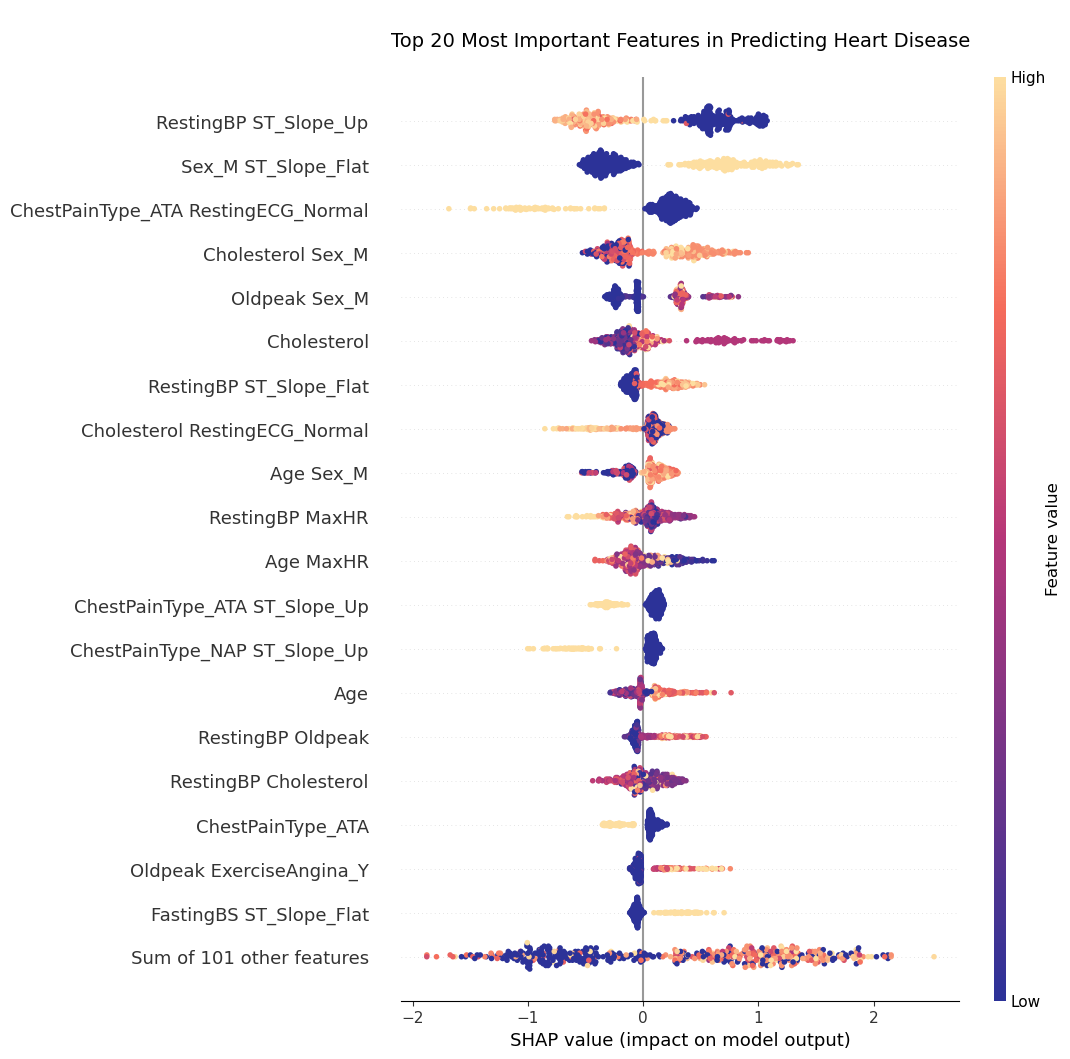

In [14]:
sunset=LinearSegmentedColormap.from_list('sunset', [(0, '#2C3298'), (0.5, '#B53679'),
                                                    (.75, '#F56C5B'), (1, '#FDDEA0')], N=256)
explainer = shap.Explainer(lgbm, X_train)
shap_values = explainer(X_train)
plt.title(label="\nTop 20 Most Important Features in Predicting Heart Disease\n", fontsize=14)
shap.plots.beeswarm(shap_values, order=shap_values.abs.mean(0), max_display=20, 
                    color=sunset, plot_size=[9,12]) 

The summary plot of Shapley values shows the top 20 predictors of heart disease arranged in order of importance. Each point on the graph represents an observation from the training set. When the points are to the right of the 0-line, this indicates there is a higher likelihood of being diagnosed with heart disease, while points to the left indicate a lower likelihood. The values for each feature is shown by the color of the points, with light orange representing high feature values and dark blue representing low feature values. The shape of the points in each row is based on the amount of overlapping observations for that feature.

Nearly all of the variables in the plot are interaction terms that were added to the model, along with three individual features, Cholesterol, Age, and Atypical Chest Pain. The variable in the first row is the interaction between `RestingBP` and `ST_Slope_Up`. Based on the feature's Shapley values, the risk of heart disease is lower in patients who have an upward ST slope and high blood pressure. For the second variable, `Sex_M ST_Slope_Flat`, the Shapley values indicate patients who are male and have a flat ST Slope are at a higher risk of cardiovascular disease. The fourth variable in the plot, `Cholesterol Sex_M`, shows that men who have high cholesterol are more likely to be diagnosed with heart disease.

The order of importance in the summary plot is calculated by the feature's average absolute Shapley value, which measures how much the feature changes the predicted probability of heart disease on average. There are 19 features that contribute to the model's prediction by an absolute value of at least 0.1 on average. Below is a list of the final predictors selected and their feature importance. Among the most important predictors, `RestingBP` and `ST_Slope` appear in 5 of the top 20. 

In [15]:
ft_importance = pd.DataFrame({"Feature Importance":np.abs(shap_values.values).mean(0)}, index=X_train.columns)
X_cols=ft_importance.query('`Feature Importance` > 0.1').sort_values(by="Feature Importance", ascending=False)
X_cols.style.background_gradient(cmap=sunset, vmin=.001, vmax=.6).format({"Feature Importance": "{:.3f}"})

,Feature Importance
RestingBP ST_Slope_Up,0.569
Sex_M ST_Slope_Flat,0.512
ChestPainType_ATA RestingECG_Normal,0.341
Cholesterol Sex_M,0.319
Oldpeak Sex_M,0.260
Cholesterol,0.252
RestingBP ST_Slope_Flat,0.160
Cholesterol RestingECG_Normal,0.159
Age Sex_M,0.153
RestingBP MaxHR,0.151


In [16]:
# New datasets 
X_train_shap=X_train[X_cols.index]
X_val_shap=X_val[X_cols.index]
X_test_shap=X_test[X_cols.index]
print("New Dataset Shapes with Shapley Values above 0.1:")
print("Train Shape:",X_train_shap.shape)
print("Validation Shape:",X_val_shap.shape)
print("Test Shape:",X_test_shap.shape)

New Dataset Shapes with Shapley Values above 0.1:
Train Shape: (504, 18)
Validation Shape: (207, 18)
Test Shape: (207, 18)


# <div style="color:white;display:fill;border-radius:5px;background-color:#CC6C6C;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:110%"><b>7 |</b> Heart Disease Predictions</p></div>
## <b><span style='color:#CF6161'>7.1</span> | Extra Trees Classifier</b>

In [17]:
et=ExtraTreesClassifier(class_weight='balanced', random_state=92)

# Parameter tuning
grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)],
        'criterion':['gini', 'entropy'],
        'max_depth': [5, 10, 15, 20],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf':  [4, 5, 6]}

et_cv=RandomizedSearchCV(estimator=et, param_distributions=grid, scoring='roc_auc', 
                         n_iter=100, cv=5, random_state=42, n_jobs=-1)
et_cv.fit(X_train_shap, y_train)

# Best estimator
ext=et_cv.best_estimator_

# CV Scores
k_fold = StratifiedKFold(n_splits=8, shuffle=True, random_state=21) 

et_f1_cv=cross_val_score(ext, X_val_shap, y_val, cv=k_fold, scoring='f1', n_jobs=-1)
et_f1 = pd.DataFrame(data={'Score': et_f1_cv, 'Metric': 'F1', 'Model': 'Extra Trees'})
et_acc_cv=cross_val_score(ext, X_val_shap, y_val, cv=k_fold, scoring='accuracy', n_jobs=-1)
et_acc = pd.DataFrame(data={'Score': et_acc_cv, 'Metric': 'Accuracy', 'Model': 'Extra Trees'})
et_df=pd.concat([et_f1, et_acc], axis=0)

print("Grid Search CV Best AUC = {:.3f}\nBest Params: {}".format(et_cv.best_score_, et_cv.best_estimator_))
print()
print("{:.2f}% Accuracy on the validation set with a standard deviation of {:.1f}"\
      .format(et_acc_cv.mean()*100, et_acc_cv.std()*100))
print("{:.2f}% F1-score on the validation set with a standard deviation of {:.1f}"\
      .format(et_f1_cv.mean()*100, et_f1_cv.std()*100))

Grid Search CV Best AUC = 0.921
Best Params: ExtraTreesClassifier(class_weight='balanced', max_depth=10, min_samples_leaf=4,
                     min_samples_split=6, random_state=92)

84.54% Accuracy on the validation set with a standard deviation of 6.7
86.43% F1-score on the validation set with a standard deviation of 5.8


Using the Shapley features above 0.1, the Extra Trees classifier produces an Area Under the Curve (AUC) of 0.92. After tuning the hyperparameters in the model, the classifier produces an average accuracy of 84.5% and an F1-score of 86.3% on the validation set, with a standard deviation of about 6.7.

## <b><span style='color:#CF6161'>7.2</span> | Random Forest Classifier</b>

In [18]:
rf=RandomForestClassifier(class_weight='balanced', random_state=92)

# Parameter tuning
grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)],
        'criterion':['gini', 'entropy'],
        'max_depth': [3, 7, 14, 21],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf':  [3, 5, 7],
        'max_features': [None, 'sqrt'],
        'max_leaf_nodes': [None, 5, 10, 15, 20],
        'min_impurity_decrease': [0.001, 0.01, 0.05, 0.1],
        'bootstrap': [True, False]}

rf_cv=RandomizedSearchCV(estimator=rf, param_distributions=grid, scoring='roc_auc', 
                         n_iter=100, cv=5, random_state=42, n_jobs=-1)
rf_cv.fit(X_train_shap, y_train)

# Best estimator
rf=rf_cv.best_estimator_

# CV Scores
rf_f1_cv=cross_val_score(rf, X_val_shap, y_val, cv=k_fold, scoring='f1', n_jobs=-1)
rf_f1 = pd.DataFrame(data={'Score': rf_f1_cv, 'Metric': 'F1', 'Model': 'Random Forest'})
rf_acc_cv=cross_val_score(rf, X_val_shap, y_val, cv=k_fold, scoring='accuracy', n_jobs=-1)
rf_acc = pd.DataFrame(data={'Score': rf_acc_cv, 'Metric': 'Accuracy', 'Model': 'Random Forest'})
rf_df=pd.concat([rf_f1, rf_acc], axis=0)

print("Grid Search CV Best AUC = {:.3f}\nBest Params: {}".format(rf_cv.best_score_, rf_cv.best_estimator_))
print()
print("{:.2f}% Accuracy on the validation set with a standard deviation of {:.1f}"\
      .format(rf_acc_cv.mean()*100, rf_acc_cv.std()*100))
print("{:.2f}% F1-score on the validation with set a standard deviation of {:.1f}"\
      .format(rf_f1_cv.mean()*100, rf_f1_cv.std()*100))

Grid Search CV Best AUC = 0.924
Best Params: RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=14,
                       max_features='sqrt', min_impurity_decrease=0.001,
                       min_samples_leaf=7, min_samples_split=10,
                       n_estimators=300, random_state=92)

85.52% Accuracy on the validation set with a standard deviation of 7.1
87.01% F1-score on the validation with set a standard deviation of 7.1


The Random Forest model improves on the performance of the Extra Trees classifier across all 3 metrics, with an Area Under the Curve of 0.924. On the validation set, the model produces an average accuracy of 85.5% and an F1-score of about 87%.

## <b><span style='color:#CF6161'>7.3</span> | AdaBoost Classifier</b>

In [19]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, class_weight='balanced'), random_state=92)

# Parameter tuning
grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)],
        'learning_rate': [0.25, 0.5, 0.75, 0.9]}

ada_cv=RandomizedSearchCV(estimator=ada, param_distributions=grid, scoring='roc_auc', 
                          n_iter=20, cv=5, random_state=92, n_jobs=-1, error_score='raise')

ada_cv.fit(X_train_shap, y_train)

# Best estimator
ada = ada_cv.best_estimator_

# CV Scores
ada_f1_cv=cross_val_score(ada, X_val_shap, y_val, cv=k_fold, scoring='f1', n_jobs=-1)
ada_f1 = pd.DataFrame(data={'Score': ada_f1_cv, 'Metric': 'F1', 'Model': 'AdaBoost'})
ada_acc_cv=cross_val_score(ada, X_val_shap, y_val, cv=k_fold, scoring='accuracy', n_jobs=-1)
ada_acc = pd.DataFrame(data={'Score': ada_acc_cv, 'Metric': 'Accuracy', 'Model': 'AdaBoost'})
ada_df=pd.concat([ada_f1, ada_acc], axis=0)

print("Grid Search CV Best AUC = {:.3f}\nBest Params: {}".format(ada_cv.best_score_, ada_cv.best_estimator_))
print()
print("{:.2f}% accuracy on the validation set with a standard deviation of {:.1f}"\
      .format(ada_acc_cv.mean()*100, ada_acc_cv.std()*100))
print("{:.2f}% F1-score on the validation set with a standard deviation of {:.1f}"\
      .format(ada_f1_cv.mean()*100, ada_f1_cv.std()*100))

Grid Search CV Best AUC = 0.899
Best Params: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=1),
                   learning_rate=0.25, n_estimators=100, random_state=92)

84.58% accuracy on the validation set with a standard deviation of 5.4
85.28% F1-score on the validation set with a standard deviation of 5.7


We see a slight decline in performance in the AdaBoost model. The AUC decreased to 0.897 and the overall accuracy and F1-score dropped to 84% and 85% respectively, although the model produces a smaller standard deviation than the others.

## <b><span style='color:#CF6161'>7.4</span> | Gradient Boosting</b>

In [20]:
gbm = lgb.LGBMClassifier(class_weight='balanced', random_state=92)

# Parameter tuning
grid = {'boosting_type': ['gbdt', 'dart'],
        'num_leaves': [int(x) for x in np.linspace(start = 20, stop = 50, num = 7)],
        'max_depth' : [-1, 3, 7, 14, 21],
        'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.5, 1],
        'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)],
        'min_split_gain': [0.00001, 0.0001, 0.001, 0.01, 0.1],
        'min_child_samples': [3, 5, 7],
        'subsample': [0.5, 0.8, 0.95],
        'colsample_bytree': [0.6, 0.75, 1]}

gbm_cv=RandomizedSearchCV(estimator=gbm, param_distributions=grid, scoring='roc_auc', 
                         n_iter=100, cv=5, random_state=92, n_jobs=-1)

gbm_cv.fit(X_train_shap, y_train)

# Best params
gbm = gbm_cv.best_estimator_

# CV Scores
gbm_f1_cv=cross_val_score(gbm, X_val_shap, y_val, cv=k_fold, scoring='f1', n_jobs=-1)
gbm_f1 = pd.DataFrame(data={'Score': gbm_f1_cv, 'Metric': 'F1', 'Model': 'Gradient Boosting'})
gbm_acc_cv=cross_val_score(gbm, X_val_shap, y_val, cv=k_fold, scoring='accuracy', n_jobs=-1)
gbm_acc = pd.DataFrame(data={'Score': gbm_acc_cv, 'Metric': 'Accuracy', 'Model': 'Gradient Boosting'})
gbm_df = pd.concat([gbm_f1, gbm_acc], axis=0)

print("Grid Search CV Best AUC = {:.3f}\nBest Params: {}".format(gbm_cv.best_score_, gbm_cv.best_estimator_))
print()
print("{:.1f}% average accuracy on the validation set with a standard deviation of {:.2f}"\
      .format(gbm_acc_cv.mean()*100, gbm_acc_cv.std()*100))
print("{:.1f}% average F1-score on the validation set with a standard deviation of {:.2f}"\
      .format(gbm_f1_cv.mean()*100, gbm_f1_cv.std()*100))

Grid Search CV Best AUC = 0.924
Best Params: LGBMClassifier(boosting_type='dart', class_weight='balanced',
               colsample_bytree=1, learning_rate=0.5, max_depth=7,
               min_child_samples=7, min_split_gain=0.0001, n_estimators=300,
               num_leaves=50, random_state=92, subsample=0.8)

87.5% average accuracy on the validation set with a standard deviation of 6.84
88.3% average F1-score on the validation set with a standard deviation of 7.18


The Gradient Boosting model produces the highest Area Under the Curve out of the classifiers at 0.925. In addition, the model increases the accuracy to almost 89% and the F1-score to 90% on the validation set.

# <div style="color:white;display:fill;border-radius:5px;background-color:#CC6C6C;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:110%"><b>8 |</b> Model Comparison</p></div>
## <b><span style='color:#CF6161'>8.1</span> | Model Performance on the Validation Set</b>

In [21]:
plot_df=pd.concat([et_df, rf_df, ada_df, gbm_df], axis=0)
plot_df['Score']=plot_df.Score.mul(100)
fig = px.box(plot_df, x="Model", y="Score", color="Metric", 
             title="Model Performance on the Validation Set",
             color_discrete_sequence = ['#95C8C3' , '#45968E'])
fig.update_layout(template=temp, xaxis_title='Model', yaxis_ticksuffix='%')
fig.update_xaxes(categoryorder='median descending')
fig.show()

Comparing the cross-validation results in the boxplots above, we see the Gradient Boosting model produces the highest median F1-score of 90.3% and the highest median accuracy of 88.5%. It also has the smallest spread in the distribution with a standard deviation of about 3. The Random Forest model comes in a close second place with an 89.7% median F1-score and an 88.2% median accuracy, although it has slightly more variability in the scores.

## <b><span style='color:#CF6161'>8.2</span> | Model Performance on the Test Set</b>

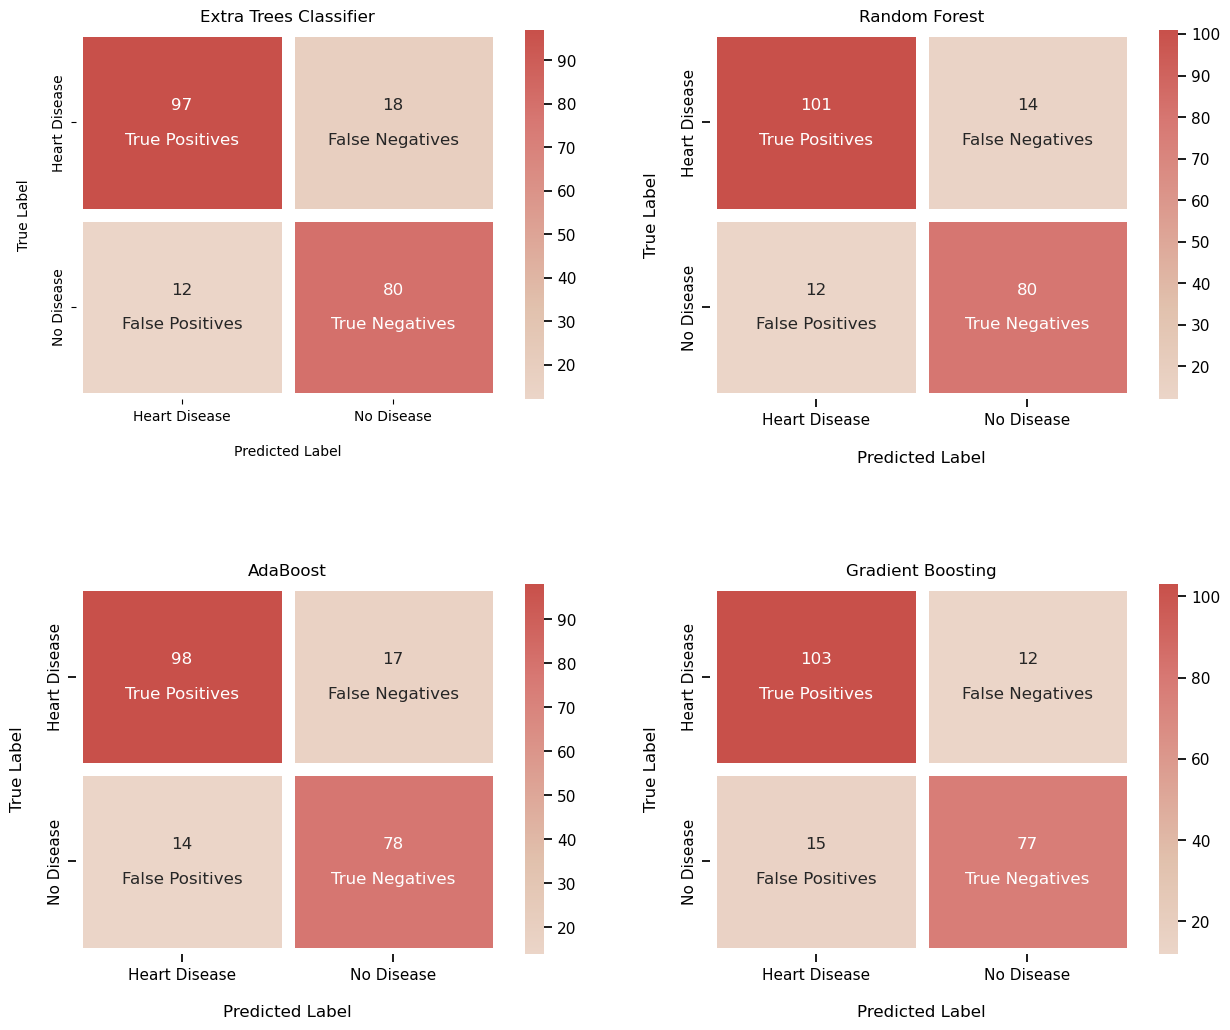

In [22]:
warm=LinearSegmentedColormap.from_list('warm', 
                                       [(0, '#EBD5C8'), 
                                        (0.25, '#E1C1AD'),
                                        (.75, '#D77873'), 
                                        (1, '#C8504A')], N=256)

# Confusion Matrix
models={"Extra Trees Classifier":ext, "Random Forest": rf,
        "AdaBoost": ada, "Gradient Boosting": gbm}

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

for i, mod in enumerate(models.items()):
    ax = plt.subplot(2, 2, i+1)
    m=list(models.values())[i]
    y_preds=m.predict(X_test_shap)
    cm = confusion_matrix(y_test, y_preds, labels=[1,0])
    classes=['Heart Disease','No Disease']
    label = ['True Positives', 'False Negatives', 'False Positives', 'True Negatives']
    annot = [f'{i}\n\n{j}' for i, j in zip(cm.flatten(), label)]
    annot = np.asarray(annot).reshape(2,2)

    sns.set_context('notebook') 
    ax = sns.heatmap(cm, annot=annot, fmt='', cmap=warm, linecolor='white', linewidths=8)
    ax.set_title(list(models.keys())[i])
    ax.set_xlabel('\nPredicted Label')
    ax.set_ylabel('True Label\n')
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)

The confusion matrix results show how many patients the models correctly predicted heart disease in and how many were misclassified. On the test set, the Gradient Boosting model classified the highest amount of True Positives (patients with heart disease), as well as the highest amount of True Negative (patients without heart disease).

# <div style="color:white;display:fill;border-radius:5px;background-color:#CC6C6C;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:110%"><b>9 |</b> ROC Curves</p></div>

In [23]:
# ROC Curves
fpr = {}
tpr = {}
roc_auc = {}
thresh = {}

models=[ext, rf, ada, gbm]
    
for i in range(len(models)):
    m=models[i]
    y_probs=m.predict_proba(X_test_shap)
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_probs[:,1], pos_label=1)
    roc_auc[i] = cross_val_score(m, X_test_shap, y_test, cv=k_fold, 
                                 scoring='roc_auc', n_jobs=-1).mean()
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr[0], y=tpr[0], line=dict(color='#5758A3', width=2.5), opacity=0.7,
                         hovertemplate = 'Extra Trees True positive rate = %{y:.3f}, False positive rate = %{x:.3f}<extra></extra>',
                         name='Extra Trees ROC Curve (AUC = {:.3f})'.format(roc_auc[0])))
fig.add_trace(go.Scatter(x=fpr[1], y=tpr[1], line=dict(color='#53A9BA', width=2.5), opacity=0.7,
                         hovertemplate = 'Random Forest True positive rate = %{y:.3f}, False positive rate = %{x:.3f}<extra></extra>',
                         name='Random Forest ROC Curve (AUC = {:.3f})'.format(roc_auc[1])))
fig.add_trace(go.Scatter(x=fpr[2], y=tpr[2], line=dict(color='#026964', width=2.5), opacity=0.7,
                         hovertemplate = 'AdaBoost True positive rate = %{y:.3f}, False positive rate = %{x:.3f}<extra></extra>',
                         name='AdaBoost ROC Curve (AUC = {:.3f})'.format(roc_auc[2])))
fig.add_trace(go.Scatter(x=fpr[3], y=tpr[3], line=dict(color='#82C394', width=2.5), opacity=0.8,
                         hovertemplate = 'Gradient Boosting True positive rate = %{y:.3f}, False positive rate = %{x:.3f}<extra></extra>',
                         name='Gradient Boosting ROC Curve (AUC = {:.3f})'.format(roc_auc[3])))
fig.add_shape(type="line", xref="x", yref="y", x0=0, y0=0, x1=1, y1=1, 
              line=dict(color="Black", width=1, dash="dot"))
fig.update_layout(template=temp, title="ROC Curve Comparison on the Test Set", hovermode="x unified", 
                  hoverlabel = dict(bgcolor="white",font_size=12), xaxis=dict(hoverformat=".2f"),
                  xaxis_title='False Positive Rate (1 - Specificity)', yaxis_title='True Positive Rate (Sensitivity)', 
                  legend=dict(y=.12, x=1, xanchor="right",bordercolor="black",borderwidth=.5, font=dict(size=14)),
                  height=600, width=700)
fig.show()

The ROC Curves show how well the models perform at different thresholds. The y-axis shows the True Positive Rate, or Sensitivity of the models, which is a measure of how well the model identifies patients with heart disease (true positives) and the False Positive Rate along the x-axis shows how many patients the model misclassifies as false positives. A model with a curve near the top left of the graph, with a higher true positive rate and a lower false positive rate, indicates a better capability to distinguish between the classes. In the plot above, all of the models produce strong results on the test set. Gradient Boosting provides the highest Area Under the Curve overall at 0.927, although at certain thresholds, we see the Random Forest model produces slightly better results where the curve surpasses the Gradient Boosting model.

# <div style="color:white;display:fill;border-radius:5px;background-color:#CC6C6C;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:110%"><b>10 |</b> Conclusion</p></div>
In detecting cardiovascular disease, Shapley values were used to develop a Gradient Boosting model that can predict the likelihood of a heart disease diagnosis with an Area Under the Curve of 0.927. Using Shapley values, we also identified key indicators of heart disease and their influence in predicting a positive diagnosis. Some of the most important predictors in the model were the interaction effects between a patient's medical information, especially in features that included a patient's Age, Cholesterol, Blood Pressure, ST Slope, and Chest Pain type. In selecting the best model, Gradient Boosting provided the strongest results overall and can be used in the early detection and diagnosis of heart disease with an overall F1-Score of 90% and an accuracy of 89%.

<br>

## <p style='color:#CF6161;text-align:center'>Thank you for reading!<br>Let me know if you have any questions and I look forward to any suggestions 🙂</p>